### Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

###### seed random number generator

In [3]:
np.random.seed(1717)

###### load dataset

In [4]:
mnist = fetch_mldata('MNIST original')

/home/doron/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/home/doron/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
mnist.data.shape, mnist.target.shape, np.unique(mnist.target)

((70000, 784), (70000,), array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]))

### Define useful functions

In [6]:
def plot_sample(x, img_size=(28, 28)):
    plt.figure(figsize=(4.2, 4))
    plt.imshow(x.reshape(img_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())

def random_permutation_inversion_symmetric_features(X, permutation):
    """inversion symmetry invariant features - random products of pairs"""
    _, n_features = X.shape
    assert n_features==len(permutation)
    result = X * X[:, permutation]
    return result

def accuracy(y_true, y_pred):
    """fraction of predictions that are correct"""
    return (y_true==y_pred).sum()/len(y_true)

### test useful functions:

###### test the accuracy function

In [7]:
assert accuracy(np.array([1,1]), np.array([1,0])) == 0.5

#### test that the permutation features generator is working correctly

A = random input

Symmetry invariant features should be the same for A and -A

In [8]:

A = np.random.rand(20,30)*2 - 1

# if the using the identity permutation, the result should be just A**2
_n_features = A.shape[1]
identity_permutation = np.arange(_n_features)
np.testing.assert_allclose(A**2,
                           random_permutation_inversion_symmetric_features(A, permutation=identity_permutation))

# fixed, but randomly selected permutation:
_permutation = np.random.permutation(_n_features)

B1 = random_permutation_inversion_symmetric_features(A, permutation=_permutation)
B2 = random_permutation_inversion_symmetric_features(-A, permutation=_permutation)

np.testing.assert_allclose(B1, B2)


###### test plotting

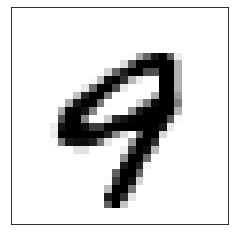

In [9]:
plot_sample(mnist.data[-1])

### Data preparation

In [10]:
X = mnist.data
Y = mnist.target
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling
X = 2*X - 1 # [-1,1] scaling

In [11]:
X.max(), X.min()

(0.999999215686582, -1.0)

In [12]:
X.shape, Y.shape

((70000, 784), (70000,))

###### verify grayscale inversion is just changing the sign:

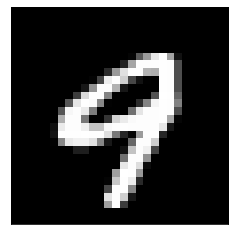

In [13]:
plot_sample(-X[-1])

### Training

###### Training on the original dataset

In [14]:
hidden_layer_sizes = (10, 5)

solver = 'lbfgs'

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

model1 = MLPClassifier(solver=solver,
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=1,
                        early_stopping=True)

model1.fit(X_train, Y_train);

###### training on both the original data and the inverted data

In [16]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=17)

model2 = MLPClassifier(solver=solver,
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=71,
                        early_stopping=True)

# augment the data
_X_train_2 = np.vstack((X_train_2, -X_train_2))
_Y_train_2 = np.hstack((Y_train_2,  Y_train_2))

_X_train_2, _Y_train_2 = shuffle(_X_train_2, _Y_train_2, random_state=176)

assert _X_train_2.shape[1]==X_train_2.shape[1]

model2.fit(_X_train_2, _Y_train_2);

###### train with random permutation symmetric features

In [17]:
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=717)

model3 = MLPClassifier(solver=solver,
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=771,
                        early_stopping=True)

# fixed, but randomly selected permutation:
n_features = X.shape[1]
permutation = np.random.permutation(n_features)

XX_train_3 = random_permutation_inversion_symmetric_features(X_train_3, permutation=permutation)
XX_test_3 = random_permutation_inversion_symmetric_features(X_test_3, permutation=permutation)

np.testing.assert_allclose(XX_test_3, 
                           random_permutation_inversion_symmetric_features(-X_test_3, permutation=permutation))

model3.fit(XX_train_3, Y_train_3);

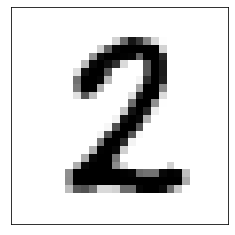

In [18]:
idx = 17760

plot_sample(X[idx])

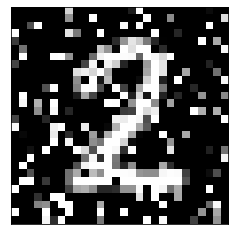

In [19]:
plot_sample(random_permutation_inversion_symmetric_features(np.array([X[idx]]), permutation=permutation))

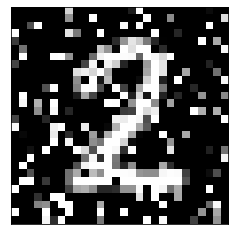

In [20]:
plot_sample(random_permutation_inversion_symmetric_features(np.array([-X[idx]]), permutation=permutation))

###### accuracy results

In [21]:
PURPLE = '\033[95m'
CYAN = '\033[96m'
DARKCYAN = '\033[36m'
BLUE = '\033[94m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
RED = '\033[91m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

STYLE = DARKCYAN + BOLD

In [22]:
print("non-symmetry-invariant models")

print("Training only on X_train, accuracy on X_test")
print(STYLE + "{:.3f}".format(accuracy(Y_test, model1.predict(X_test))) + END)

print("Training only on X_train, accuracy on -X_test")
print(STYLE + "{:.3f}".format(accuracy(Y_test, model1.predict(-X_test))) + END)


print("Training on X_train and -X_train, accuracy on X_test")
print(STYLE + "{:.3f}".format(accuracy(Y_test_2, model2.predict(X_test_2))) + END)


print("Training on X_train and -X_train, accuracy on -X_test")
print(STYLE + "{:.3f}".format(accuracy(Y_test_2, model2.predict(-X_test_2))) + END)


non-symmetry-invariant models
Training only on X_train, accuracy on X_test
0.666
Training only on X_train, accuracy on -X_test
0.002
Training on X_train and -X_train, accuracy on X_test
0.753
Training on X_train and -X_train, accuracy on -X_test
0.308


In [23]:
print("symmetry-invariant model")

print("Using randomized features")
print(STYLE +  "{:.3f}".format(accuracy(Y_test_3, model3.predict(XX_test_3))) + END)

symmetry-invariant model
Using randomized features
0.917


# Without symmetry ~0.75 accuracy. With symmetry ~ 0.9 !